In [44]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
# from tensorflow import keras

# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras import optimizers

import skimage as ski
from skimage.transform import resize
from sklearn.model_selection import train_test_split

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counter intuitive

### Working with a pretrained model:
- Feature Extraction
    - Add new classifiers
- Fine-Tuning
    - Unfreeze a few of the top layers

In [48]:
gc.collect()

0

In [6]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = (255, 255)

In [57]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

In [ ]:
# def mapto1hot():
#     """
#     One hot encoding for the number of categories we will be looking at. 
#     """
#     ytrain_1hot = keras.utils.to_categorical(ytrain, num_classes = len(categories))
#     yval_1hot = keras.utils.to_categorical(yval, num_classes = len(categories))
#     ytest_1hot = keras.utils.to_categorical(ytest, num_classes = len(categories))
#     
#     return ytrain_1hot, yval_1hot, ytest_1hot

In [56]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 83613 files belonging to 8 classes.
Found 35833 files belonging to 8 classes.


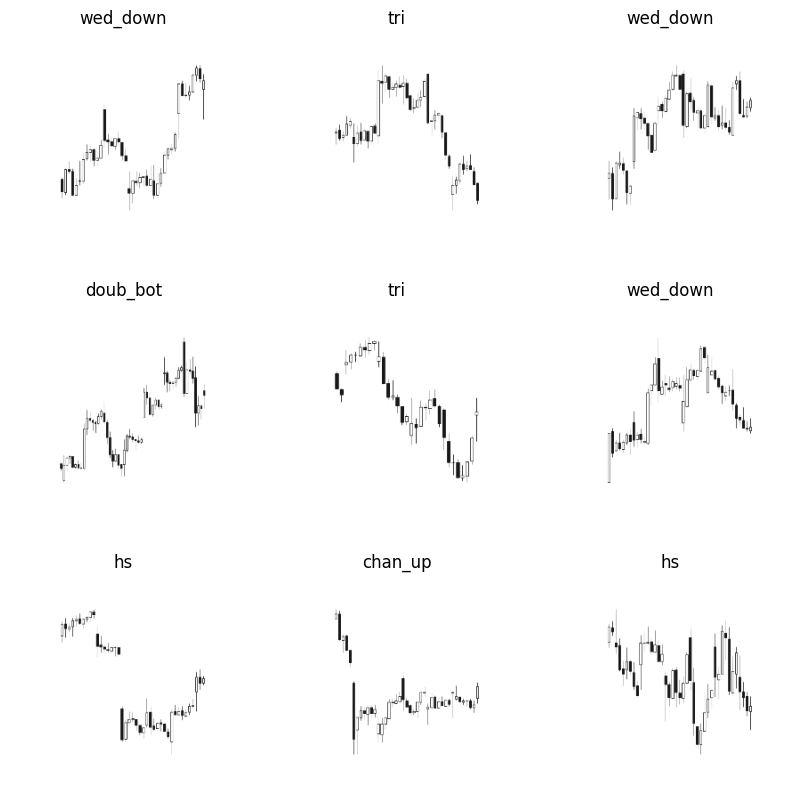

In [58]:
# Test by printing first ten images from the training dateset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [59]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 896
Number of test batches: 224


In [60]:
# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [61]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

C:\Users\Nick\AppData\Local\Temp\ipykernel_36108\591084452.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [62]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


### Feature extraction step
- beginning by freezing the the weights. Return to this later.

In [63]:
base_model.trainable = False